# FDEM Horizontal Electric Dipole

In this notebook, we compare a 3D cyl code with an analytic for a horizontal electric dipole in the frequency domain. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import tarfile

from SimPEG import Mesh, Utils, Maps
from discretize import utils
import geoana

import casingSimulations

%matplotlib inline

In [2]:
simDir = 'compare_3D_hed'

In [3]:
compare_with_download = True

## set up a wholeSpace

In [4]:
sigma_back = 1e-1

cyl_model = casingSimulations.model.Wholespace(
    sigma_back = sigma_back,
    src_a = np.r_[490., np.pi, 5.],
    src_b = np.r_[510., np.pi, 5.],
    freqs = [1.],
)

In [5]:
npadx, npadz = 9, 9
dx2 = 1000. 
csx = 20.
csz = 20.

ncy = 3
nstretchy = 4
stretchfact = 1.6
hy = utils.meshTensor(
    [(1, nstretchy, -stretchfact), (1, ncy), (1, nstretchy, stretchfact)]
)
hy = hy * 2*np.pi/hy.sum()

cylMeshGen = casingSimulations.CylMeshGenerator(
    modelParameters=cyl_model, 
    npadx=npadx, 
    npadz=npadz, 
    domain_x=dx2, 
    hy=hy, 
    csx=csx, 
    csz=csz
)

In [6]:
cylmesh = cylMeshGen.mesh

/anaconda/lib/python2.7/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


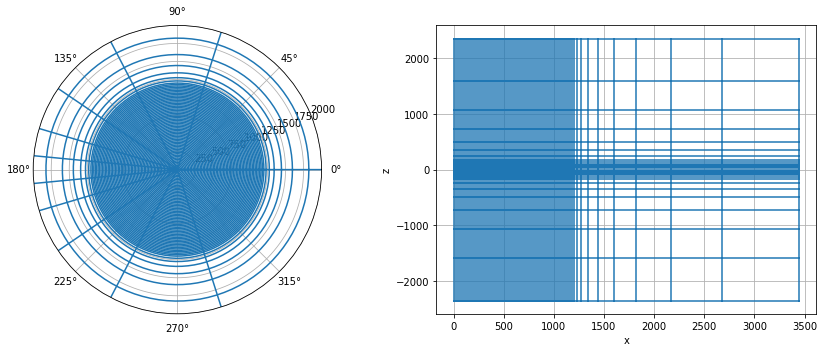

In [7]:
fig = plt.figure(figsize=(12, 5))
ax0 = plt.subplot(121, projection='polar')
ax1 = plt.subplot(122)

ax0.set_rlim([0.,2e3])

cylmesh.plotGrid(ax=[ax0, ax1])

In [8]:
cyl_model.skin_depth()

array([ 1591.54943092])

In [9]:
src = casingSimulations.sources.HorizontalElectricDipole(
    modelParameters=cyl_model, meshGenerator=cylMeshGen
)

(0.0, 1200.0)

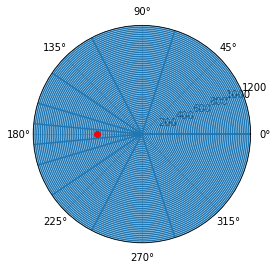

In [10]:
ax = plt.subplot(111, projection='polar')
cylmesh.plotGrid(ax=ax, slice='z')
ax.plot(cylmesh.gridFx[src.surface_wire,1], cylmesh.gridFx[src.surface_wire,0], 'ro')
ax.set_rlim([0., 1200.])

(-100.0, 100.0)

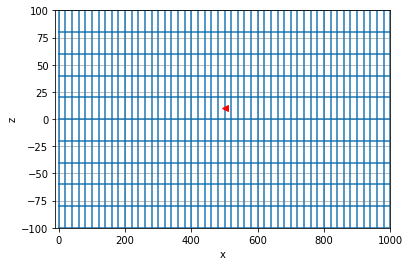

In [11]:
fig, ax = plt.subplots(1, 1)
cylmesh.plotGrid(ax=ax, slice='theta')
src.plot(ax=ax)

ax.set_xlim([-10., 1000.])
ax.set_ylim([-100., 100.])

In [12]:
src.validate()

True

In [13]:
cylSimulation = casingSimulations.run.SimulationFDEM(
    modelParameters=cyl_model, meshGenerator=cylMeshGen, src=src, 
    directory=simDir 
)

In [14]:
cylFields = cylSimulation.run(save=False)

Validating parameters...
      max x: 3446.6015625, min z: -2346.6015625, max z: 2346.6015625, nC: 21252
Starting SimulationFDEM
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 8.12306308746


In [15]:
jcyl = cylFields[:,'j']

In [16]:
theta_ind = 0
jplt = casingSimulations.face3DthetaSlice(cylmesh, jcyl, theta_ind=theta_ind)

In [17]:
mesh2D = Mesh.CylMesh([cylmesh.hx, 1., cylmesh.hz], x0=cylmesh.x0)

(<matplotlib.collections.QuadMesh at 0x1134331d0>,
 <matplotlib.colorbar.Colorbar at 0x113256bd0>)

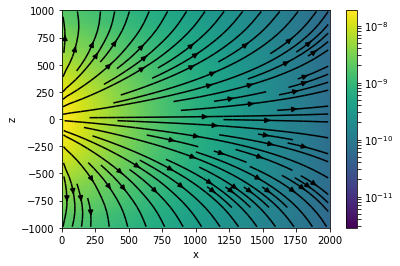

In [18]:
fig, ax = plt.subplots(1,1)
casingSimulations.plotFace2D(
    mesh2D,
    jplt, real_or_imag='real', ax=ax, range_x=np.r_[0., 2000.],
    range_y=np.r_[-1000., 1000.], sample_grid=np.r_[20., 20.],
    log_scale=True
)

In [19]:
theta = cylmesh.vectorCCy[theta_ind]

gridFx = mesh2D.gridFx
gridFx[:,1] = theta

gridFz = mesh2D.gridFz
gridFz[:,1] = theta

gridFx = utils.cyl2cart(gridFx)
gridFz = utils.cyl2cart(gridFz)

edipole = geoana.em.fdem.ElectricDipoleWholeSpace(
    location=np.r_[-500., 0., 12.5], orientation='x', sigma=cyl_model.sigma_back, current=1., 
    length=20., frequency=cyl_model.freqs[0]
)

eana_Fx = edipole.electric_field(gridFx)
eana_Fz = edipole.electric_field(gridFz)

eana_x, eana_y = eana_Fx[:, 0], eana_Fx[:, 1]
eana_z = eana_Fz[:, 2]

eana_x = (np.cos(theta) * eana_x + np.sin(theta) * eana_y)

eana = utils.mkvc(np.hstack([eana_x, eana_z]),2)

                
jana = cyl_model.sigma_back * eana

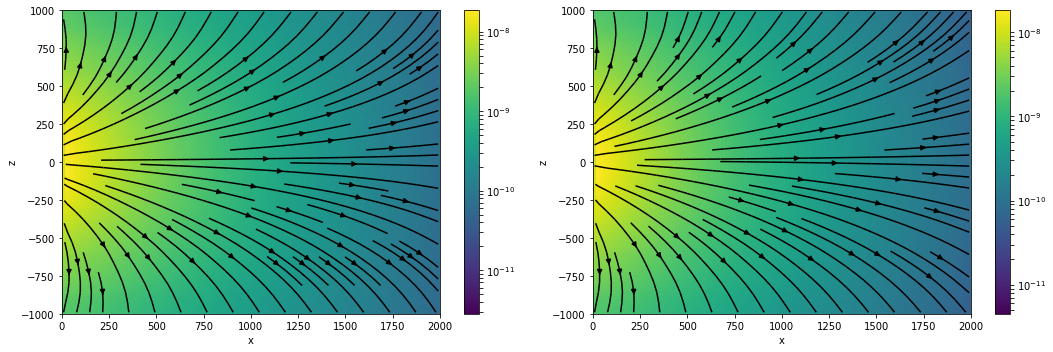

In [20]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

casingSimulations.plotFace2D(
    mesh2D,
    jplt, real_or_imag='real', ax=ax[0], range_x=np.r_[0., 2000.],
    range_y=np.r_[-1000., 1000.], sample_grid=np.r_[20., 20.],
    log_scale=True
)

casingSimulations.plotFace2D(
    mesh2D,
    jana, real_or_imag='real', ax=ax[1], range_x=np.r_[0., 2000.],
    range_y=np.r_[-1000., 1000.], sample_grid=np.r_[20., 20.],
    log_scale=True
)

plt.tight_layout()

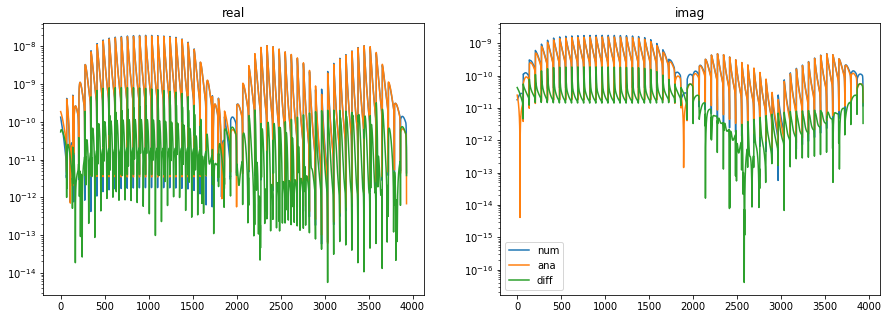

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].semilogy(np.absolute(jplt.real))
ax[0].semilogy(np.absolute(jana.real))
ax[0].semilogy(np.absolute(jplt.real - jana.real))
ax[0].set_title('real')

ax[1].semilogy(np.absolute(jplt.imag))
ax[1].semilogy(np.absolute(jana.imag))
ax[1].semilogy(np.absolute(jplt.imag - jana.imag))
ax[1].set_title('imag')

ax[1].legend(['num', 'ana', 'diff'])

In [22]:
def normalized_error(val1, val2):
    return np.linalg.norm(val1 - val2) / np.linalg.norm(0.5*(val1+val2))

In [23]:
assert normalized_error(jplt.real, jana.real) < 0.05
assert normalized_error(jplt.imag, jana.imag) < 0.07 # imag is smaller in magnitude, so need a little more wiggle room

In [24]:
if compare_with_download is True:
    f = 'compare_3D_hed'
    if not os.path.exists(f + "fields.npy"):
        download = Utils.download(
            "https://storage.googleapis.com/simpeg/heagy_2018_emcyl/{}.tar.gz".format(f)
        )  
        tar = tarfile.open(download, "r:*")
        tar.extractall()
        tar.close()
    
    hfield = np.load(f + os.path.sep + "fields.npy")
    
    assert(np.allclose(hfield, cylFields[:, 'h']))

file already exists, new file is called /Users/lindseyjh/git/simpeg-research/heagy_2018_emcyl/appendix_notebooks/compare_3D_hed.tar.gz
   saved to: /Users/lindseyjh/git/simpeg-research/heagy_2018_emcyl/appendix_notebooks/compare_3D_hed.tar.gz
Download completed!
